# Simulation Playground Notebook
This notebook is designed as a easy einterface to call the functions that we have defined

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data, preprocess_data

# Data Preparation
Let's prepare some data first to fit our model. We are specifically using ["Locus coeruleus activity strengthens prioritized memories under arousal"](https://openneuro.org/datasets/ds002011/versions/1.0.0) dataset fror now.

In [2]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

Let's preprocess our data first

In [3]:
X, Y, X_tensor, Y_tensor, scaler_X, scaler_Y, df_clean = preprocess_data(df_behavior)

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Training

In [5]:
from train import (train_feed_forward_nn,
                   train_vanilla_rnn,
                   train_vanilla_lstm,
                   train_vanilla_lc_model,
                   train_lstm_lc_model,
                   train_ff_controller
                   )
from analysis.evaluation import evaluate_model

## Fully Connected Neural Network

To illustrate our idea, we want to train 2 models from math and computer science, which is our vanilla feed forward networks and an recurrent networks.

Epoch 0, Loss: 0.23769737780094147
Epoch 100, Loss: 0.05063355714082718
Epoch 200, Loss: 0.04946153983473778
Epoch 300, Loss: 0.04855670779943466
Epoch 400, Loss: 0.047945089638233185
Epoch 500, Loss: 0.0473865270614624
Epoch 600, Loss: 0.047088317573070526
Epoch 700, Loss: 0.04675149545073509
Epoch 800, Loss: 0.04650728777050972
Epoch 900, Loss: 0.046246323734521866
Epoch 1000, Loss: 0.04608303681015968
Epoch 1100, Loss: 0.0457981713116169
Epoch 1200, Loss: 0.045739807188510895
Epoch 1300, Loss: 0.04552805423736572
Epoch 1400, Loss: 0.045462533831596375
Epoch 1500, Loss: 0.04547487571835518
Epoch 1600, Loss: 0.04508639872074127
Epoch 1700, Loss: 0.045086298137903214
Epoch 1800, Loss: 0.044910985976457596
Epoch 1900, Loss: 0.044759009033441544
Training complete!
Evaluating Model: FeedForwardNN


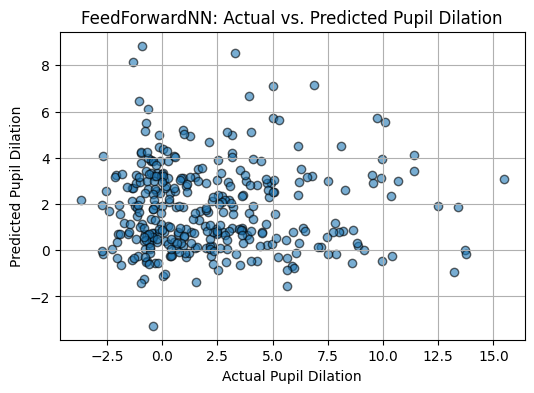

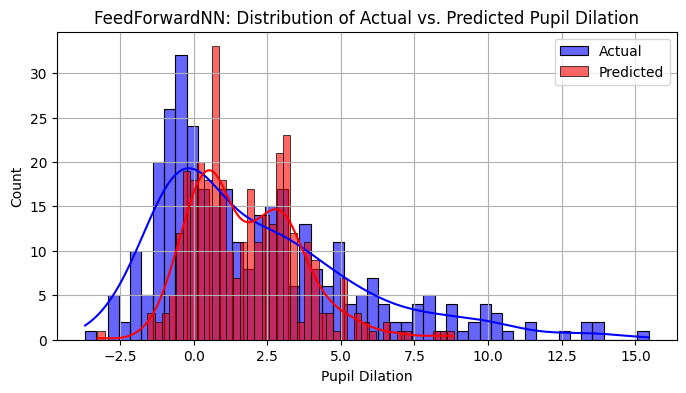

FeedForwardNN - Pearson Correlation: -0.0044


In [6]:
model_ff = train_feed_forward_nn(X_train, Y_train,epochs=2000)
evaluate_model(model_ff, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## Recurent Neural Networks

We will  do the same thing with an recurrent neural network

In [7]:
# model_rnn = train_vanilla_rnn(X_train, Y_train, epochs=2000)
# evaluate_model(model_rnn, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM Models

In [8]:
# model_lstm = train_vanilla_lstm(X_train, Y_train, epochs=5000, hidden_dim=12)
# evaluate_model(model_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LCNECortex Fitter Model

Now coming to our customized LCNECortex model

Epoch 0, Loss: 0.1970282644033432


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.023270003497600555
Epoch 200, Loss: 0.025151830166578293
Epoch 300, Loss: 0.0258818157017231
Epoch 400, Loss: 0.028753815218806267
Epoch 500, Loss: 0.03752164542675018
Epoch 600, Loss: 0.030514614656567574
Epoch 700, Loss: 0.03597131744027138
Epoch 800, Loss: 0.04604838788509369
Epoch 900, Loss: 0.03849324956536293
Epoch 1000, Loss: 0.01802116073668003
Epoch 1100, Loss: 0.024099385365843773
Epoch 1200, Loss: 0.03992822393774986
Epoch 1300, Loss: 0.023796647787094116
Epoch 1400, Loss: 0.027111578732728958
Epoch 1500, Loss: 0.02595348283648491
Epoch 1600, Loss: 0.0263212937861681
Epoch 1700, Loss: 0.04128939285874367
Epoch 1800, Loss: 0.0345517061650753
Epoch 1900, Loss: 0.04285390302538872
Training complete!
Evaluating Model: LCNECortexFitter


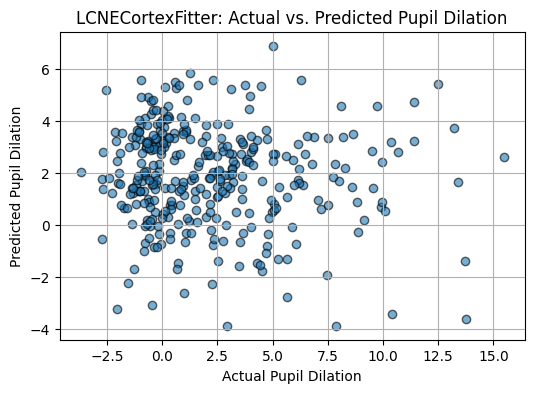

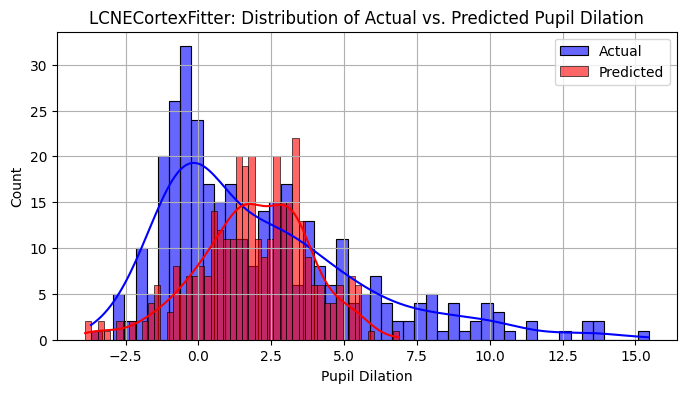

LCNECortexFitter - Pearson Correlation: -0.0793


In [9]:
model_lc_vanilla = train_vanilla_lc_model(X_train, Y_train, epochs=2000)
evaluate_model(model_lc_vanilla, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM LCNECortex Model

In [10]:
# model_lc_lstm = train_lstm_lc_model(X_train, Y_train, epochs=2000, hidden_dim=64)
# evaluate_model(model_lc_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

# FF Gadget Model

Epoch 0, Loss: 0.068893


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.022960
Epoch 200, Loss: 0.016553
Epoch 300, Loss: 0.033884
Epoch 400, Loss: 0.013070
Epoch 500, Loss: 0.023491
Epoch 600, Loss: 0.017595
Epoch 700, Loss: 0.034947
Epoch 800, Loss: 0.030919
Epoch 900, Loss: 0.019026
Epoch 1000, Loss: 0.033732
Epoch 1100, Loss: 0.023518
Epoch 1200, Loss: 0.038205
Epoch 1300, Loss: 0.023076
Epoch 1400, Loss: 0.008515
Epoch 1500, Loss: 0.025470
Epoch 1600, Loss: 0.028455
Epoch 1700, Loss: 0.012133
Epoch 1800, Loss: 0.030380
Epoch 1900, Loss: 0.019765
Epoch 2000, Loss: 0.034722
Epoch 2100, Loss: 0.016976
Early stopping triggered at epoch 2149
Training complete!
Evaluating Model: FFGadgetController


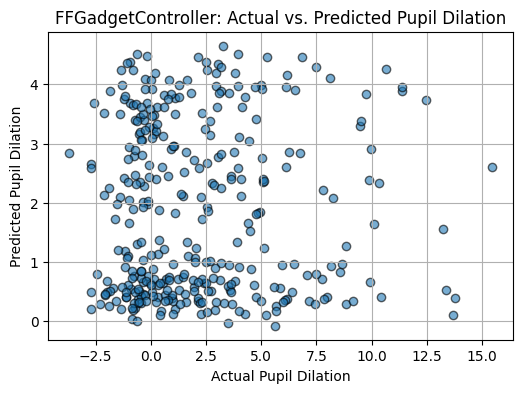

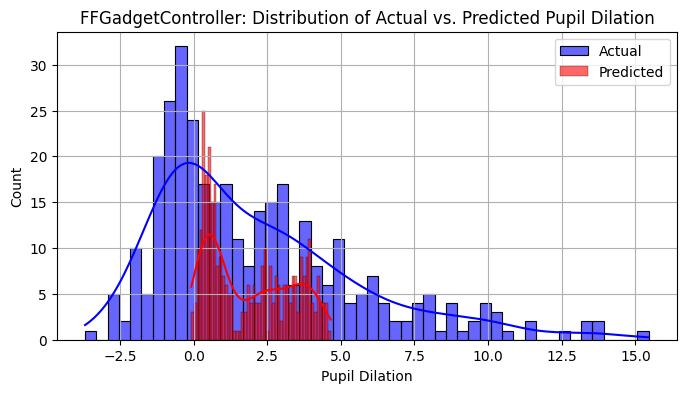

FFGadgetController - Pearson Correlation: 0.0157


In [11]:
ff_gadget = train_ff_controller(X_train, Y_train, epochs=5000, hidden_dim=264)
evaluate_model(ff_gadget, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

Interesting results

# Analysis

In [12]:
from analysis.analysis import (pca_lcne_lstm,
                               pca_feed_forward,
                               pca_lcne,
                               pca_lstm,
                               analyze_ff_gadget_activations,
)

## Feed-Forward Neural Networks

In [13]:
# pca_feed_forward(model_ff, X_tensor, df_behavior)

## LCNECortex Model

We will see that, though  under fitted with the real data, there are some structureness to the data that we can play around with since we injected mechanistic insights into it.

Text(0.5, 1.0, 'Cortex Activation Distribution')

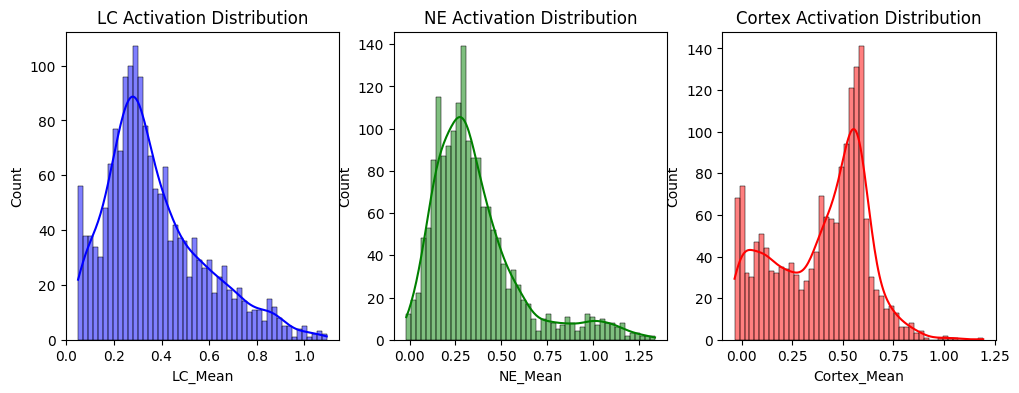

In [14]:
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, LC_raw, NE_raw, C_raw = model_lc_vanilla(X_tensor, prev_LC, prev_Cortex, return_activations=True)

act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()

df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1),
    'NE_Mean': act_ne.mean(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1),
    'PupilPred': Pupil_pred.cpu().numpy().squeeze(),
    'ActualPupil': df_clean['Event_PupilDilation'].values  # Ensure this aligns with X_tensor
})

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df_activations['LC_Mean'], kde=True, bins=50, color='blue')
plt.title("LC Activation Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_activations['NE_Mean'], kde=True, bins=50, color='green')
plt.title("NE Activation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_activations['Cortex_Mean'], kde=True, bins=50, color='red')
plt.title("Cortex Activation Distribution")

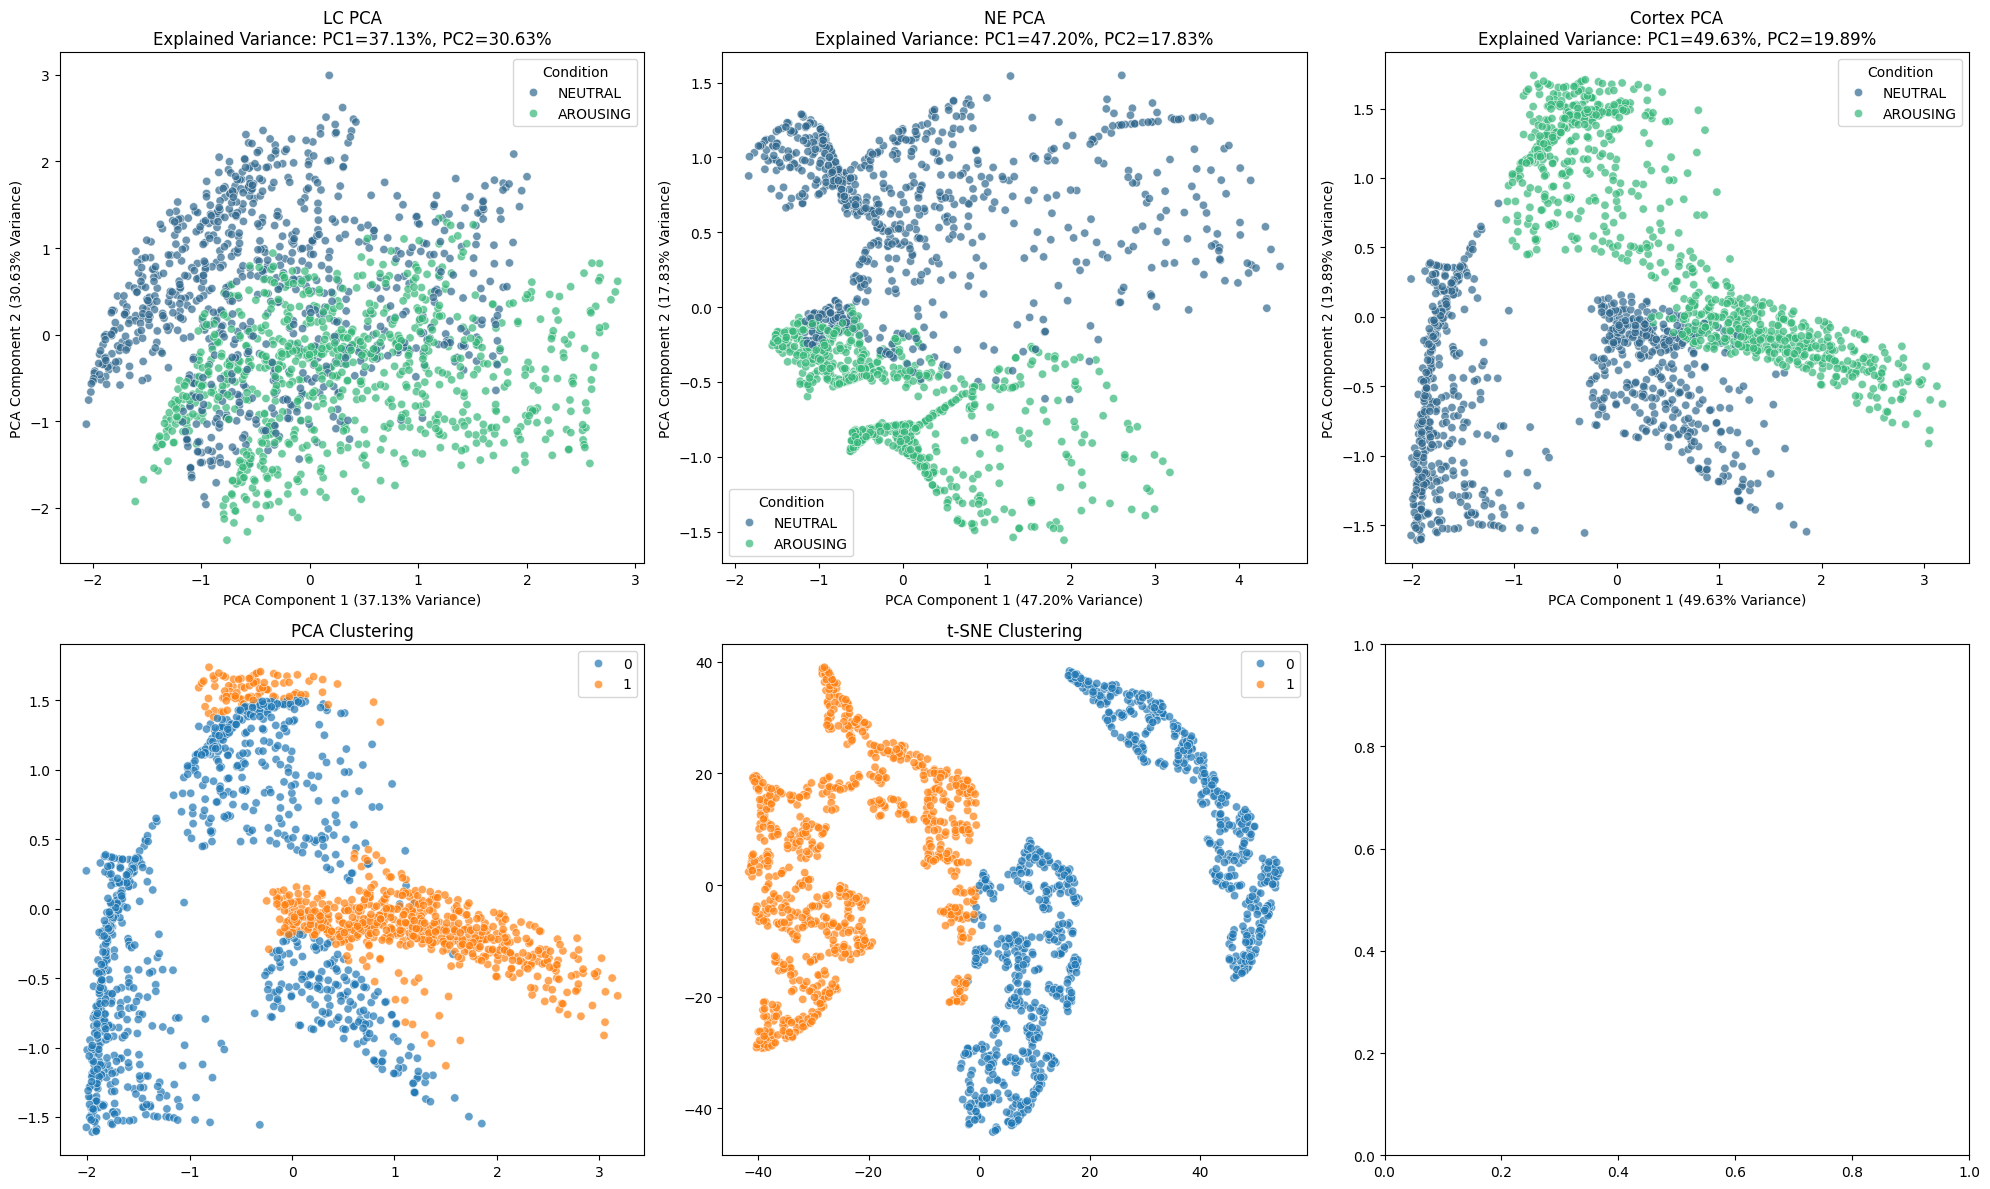

In [15]:
pca_lcne(model_lc_vanilla, X_tensor, df_clean)

## LSTM LCNECortex Model

In [16]:
# pca_lcne_lstm(model_lc_lstm, X_tensor, df_clean)

## Vanilla LSTM Comparison

In [17]:
# pca_lstm(model_lstm, X_test, df_clean)

## FF Gadget Model

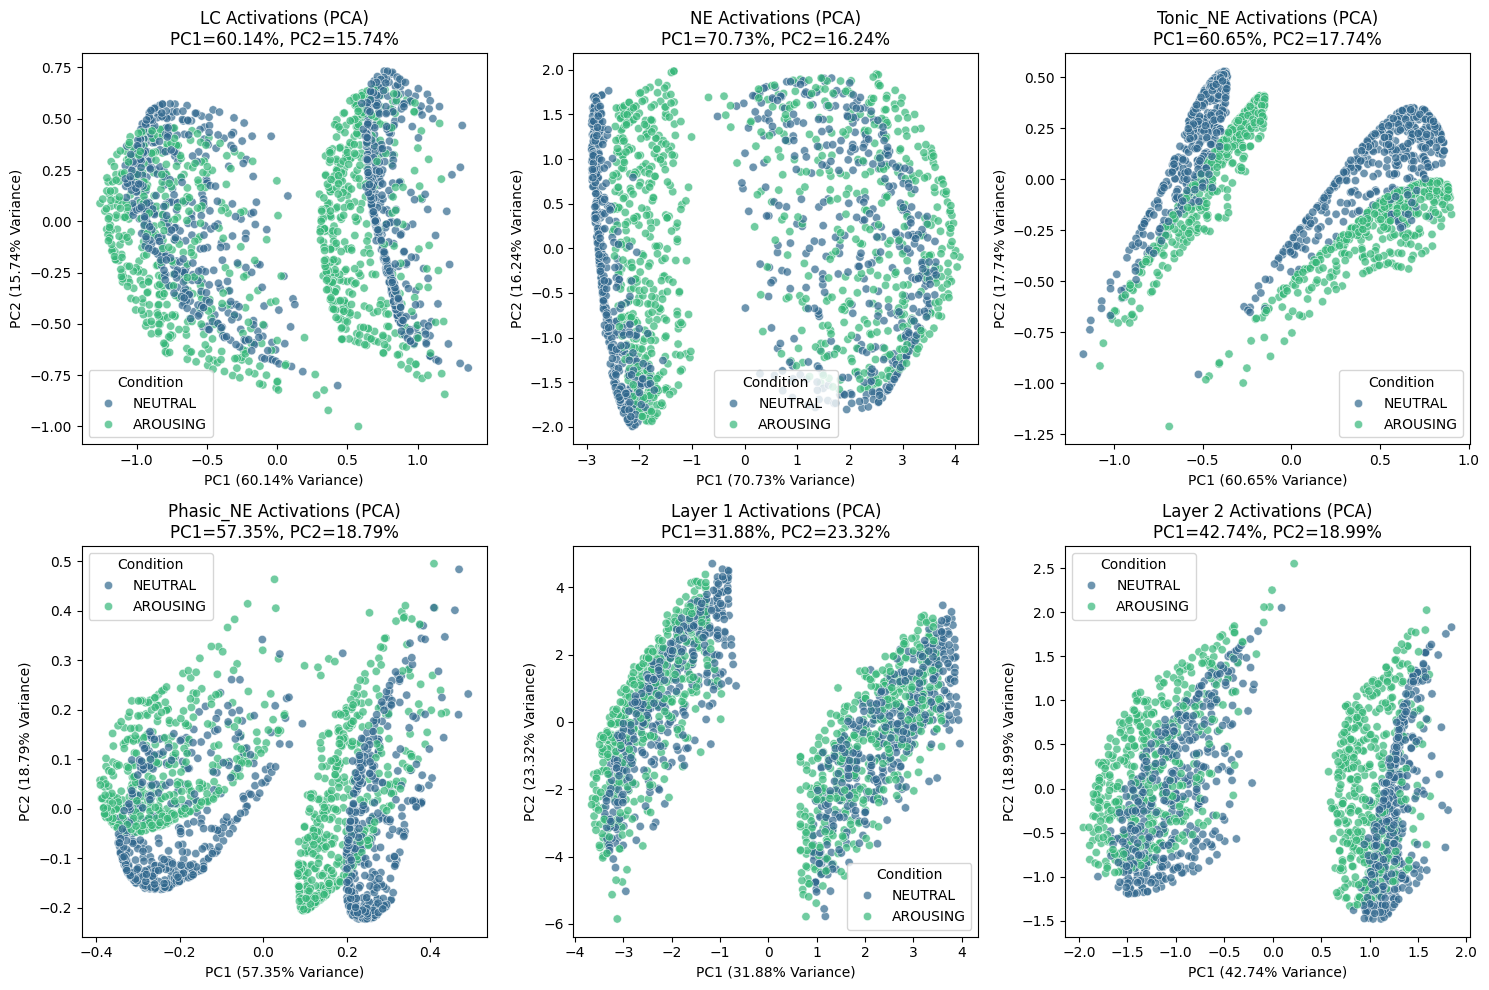

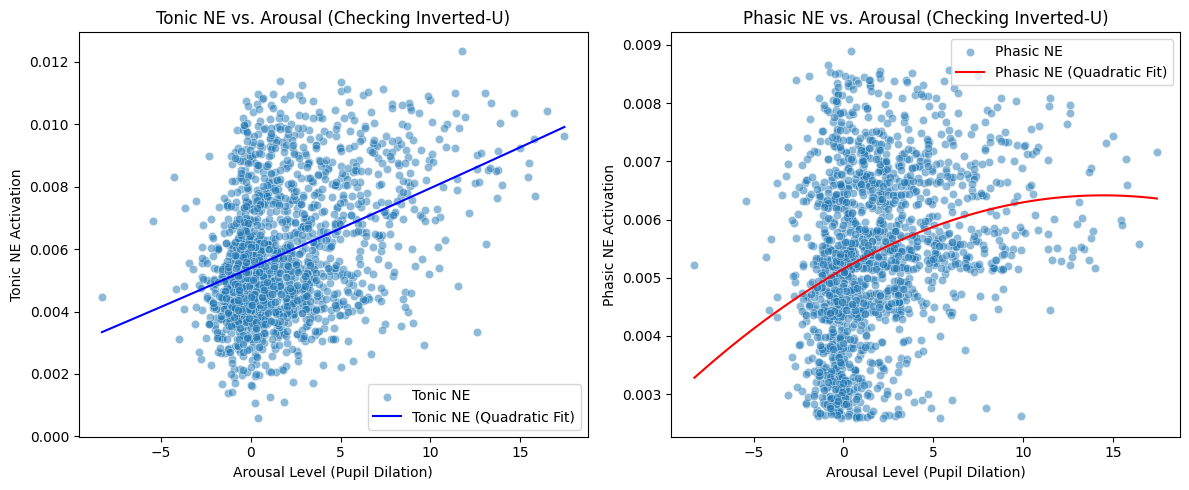


 Pearson Correlation with Actual Pupil Dilation:
LC: -0.369
NE: -0.307
Tonic_NE: 0.394
Phasic_NE: 0.286
Layer 1: -0.079
Layer 2: 0.064
Predicted Pupil Dilation: 0.445


In [18]:
analyze_ff_gadget_activations(ff_gadget, X_tensor, df_clean)

This model elarning representation is quite unstable